In [6]:
import numpy as np
import pandas as pd
import xarray as xr
import glob
from matplotlib import pyplot as plt
from numpy.polynomial import polynomial
from sklearn.linear_model import LinearRegression
import copy

# Functions

In [7]:
def doy_helper(ds):
    # Remove leap day (Feb 29)
    ds = ds.isel(
        time=~((pd.to_datetime(ds.time).day == 29)&(pd.to_datetime(ds.time).month == 2))
    )
    
    # Create day of year (DOY) array for indexing
    doy = np.tile(
        np.arange(1, 366, 1, dtype='int32'),
        len(pd.to_datetime(ds.time).year.unique())
    )

    # rework dims/coords for climo
    return ds.rename({'time':'doy'}).assign_coords({'doy':('doy', doy)})

def return_from_doy_helper(dswdoy, dswtime):

    # Remove leap day (Feb 29)
    dswtime = dswtime.isel(
        time=~((pd.to_datetime(dswtime.time).day == 29)&(pd.to_datetime(dswtime.time).month == 2))
    )

    # save time coord
    time_arr = pd.to_datetime(dswtime.time.values)

    # reverse to time instead of doy
    return dswdoy.assign_coords({'doy':('doy', time_arr)}).rename({'doy':'time'})

def get_climatology_smoothed(ds, var, window=60, fileauthor='Jhayron S. Pérez-Carrasquilla'):
    
    # Subset dataset for the period 1981-2020
    ds_clima = ds

    # adjust to doy coords/dims
    ds_clima = doy_helper(ds_clima)
    
    # Compute the daily mean for each day of the year
    climo = []
    for i in range(1, 366):
        daily_mean = ds_clima.sel(doy=i)[var].mean('doy')
        climo.append(daily_mean)
    
    # Convert to xarray Dataset with the appropriate dimensions
    attrs = ds[var].attrs
    attrs['File Author'] = fileauthor
    
    climo = xr.Dataset({
        f'{var}_climo': (['doy', 'lat', 'lon'], np.array(climo)),
    }, 
    coords={
        'doy': np.arange(1, 366, 1),
        'lat': ds.lat.values,
        'lon': ds.lon.values,
    },
    attrs=attrs
    )

    # reorder dims
    climo = climo.transpose('doy', 'lat', 'lon')

    # sanity check
    # print(climo[f'{var}_climo'].shape)
    
    # Stack climatology 3 times to handle edges
    climo_extended = xr.concat([climo, climo, climo], dim='doy')

    # Adjust coordinates after stacking to represent a larger time span
    climo_extended['doy'] = np.arange(1, 365 * 3 + 1, 1)

    # Apply rolling mean with a 60-day window for smoothing
    climo_smoothed = climo_extended.rolling(doy=window, center=True, min_periods=1).mean(skipna=True)

    # Extract the middle portion, corresponding to the original 365 days
    climo_smoothed = climo_smoothed.isel(doy=slice(365, 365 + 365))

    # sanity check
    # print(climo_smoothed[f'{var}_climo'].shape)
    
    # Reset 'day_of_year' coordinate to original range
    climo_smoothed['doy'] = np.arange(1, 366, 1)

    return climo_smoothed

def get_anomalies(ds, var, climo):

    # deep copy dataset
    anom = copy.deepcopy(ds)

    # adjust to doy coords/dims
    dstmp = doy_helper(ds)
    anom = doy_helper(anom)

    # compute doy anomalies
    for day in range(1, 366):
        
        anom[var][{'doy':(dstmp.doy == day)}] = (dstmp[var].sel(doy=day) - climo[f'{var}_climo'].sel(doy=day))

    # back to dataset
    anom = anom.rename({var:f'{var}_anom'})

    # add original time dim
    return return_from_doy_helper(anom, ds)

def fourierfilter(da, cutoff_period=10):
    
    # Compute the Fourier transform along the time axis
    fft_data = np.fft.fft(da, axis=0)
    
    # Get the frequencies corresponding to the FFT components
    freqs = np.fft.fftfreq(da.shape[0], d=1)
    # d=1 assumes daily data; adjust if different
    
    # Compute the corresponding periods (in days)
    periods = np.abs(1 / freqs)
    
    # Define the cutoff period for low-pass filter (10 days)
    cutoff_period = cutoff_period
    
    # Create a mask to filter out high-frequency components (shorter than 10 days)
    high_pass_mask = periods < cutoff_period
    
    # Apply the mask to the FFT data (set high-frequency components to zero)
    fft_data_filtered = fft_data.copy()
    fft_data_filtered[high_pass_mask, :, :] = 0
    
    # Perform the inverse FFT to get the filtered data back in the time domain
    filtered_data = np.fft.ifft(fft_data_filtered, axis=0).real
    
    # Create a new xarray DataArray to store the filtered data
    filtered_anom = xr.DataArray(
        filtered_data,
        dims=da.dims,
        coords=da.coords,
        attrs=da.attrs
    )
    return filtered_anom

# Get average time series of the region
def get_weighted_area_average(da):
    
    # Compute the cosine of the latitudes (in radians) for weighting
    # For a rectangular grid the cosine of the latitude is proportional to the grid cell area
    weights = np.cos(np.deg2rad(da.lat))
    weights.name = "weights"

    # Apply the weights and compute the mean across lat/lon
    da_weighted = da.weighted(weights)
    weighted_mean = da_weighted.mean(dim=['lat', 'lon'])
    
    return weighted_mean


def create_doy_dummy(num_yr=84):
    """Creates dummy array for indexing the non-leap year based doy time series"""
    days_per_year = 365
    years = num_yr
    day_indices = np.arange(
        0, 
        years * days_per_year, 
        days_per_year,
        dtype=int
    ).reshape(-1, 1) + np.arange(days_per_year)
    return day_indices


def get_climatology_std_smoothed(ds, var, window=60, fileauthor='Jhayron S. Pérez-Carrasquilla'):

    # Get the day of year (DOY)
    doy_tmp = create_doy_dummy(len(np.unique(pd.to_datetime(ds.time).year)))
    
    # Compute the daily standard deviation for each day of the year
    climo = []
    for i in range(0, 365):
        # grab indices for doy
        doy_indx = doy_tmp[:, i]
        
        # ensure time is first axis with transpose
        array_temp = ds[var].transpose('time', 'lat', 'lon')[doy_indx]

        # compute std for doy
        std = np.nanstd(array_temp, axis=0)
        # make nan where 0
        std[std == 0] = np.nan
        climo.append(std)
    
    # Convert to xarray Dataset with the appropriate dimensions
    attrs = ds[var].attrs
    attrs['File Author'] = fileauthor
    
    climo = xr.Dataset({
        f'{var}_climo_std': (['doy', 'lat', 'lon'], np.array(climo)),
    }, 
    coords={
        'doy': np.arange(1, 366, 1),
        'lat': ds.lat.values,
        'lon': ds.lon.values,
    },
    attrs=attrs)

    climo = climo.transpose('doy', 'lat', 'lon')
    
    # Stack climatology 3 times to handle edges
    climo_extended = xr.concat([climo, climo, climo], dim='doy')

    # Adjust coordinates after stacking to represent a larger time span
    climo_extended['doy'] = np.arange(1, 365 * 3 + 1, 1)

    # Apply rolling mean with a 60-day window for smoothing
    climo_smoothed = climo_extended.rolling(doy=window, center=True, min_periods=1).mean(skipna=True)

    # Extract the middle portion, corresponding to the original 365 days
    climo_smoothed = climo_smoothed.isel(doy=slice(365, 365 + 365))

    # Reset 'day_of_year' coordinate to original range
    climo_smoothed['doy'] = np.arange(1, 366, 1)

    return climo_smoothed

# this func is not used (below)
def standardize_anomalies(anom, var, climo_std):

    # ensure time is first dim/axis
    anom = anom.transpose('time', 'lat', 'lon')
    std_anom = copy.deepcopy(anom)
    
    # Get the day of year (DOY)
    doy_tmp = create_doy_dummy(len(np.unique(pd.to_datetime(anom.time).year)))

    for i in range(0, 365):
        
        doy_indx = doy_tmp[:, i]

        std_anom[var][doy_indx] = (
            anom[var][doy_indx] / climo_std[f'{var}_climo_std'].sel(doy=i + 1)
        )
    return std_anom

In [8]:
def extractz500_several_files(filestemp):
    listxarrays = []
    for file in filestemp:
        dstemp = xr.open_dataset(file)
        dstemp = dstemp.sel(time=slice('1940-01-01', '2100-12-31'))
        dstemp = dstemp.Z500.where((dstemp.lat>=10),drop=True)
        # Transpose the data to match the desired dimension order
        dstemp_transposed = dstemp.transpose('time', 'lat', 'lon')
        lat0=20; lat1=80; lon0=180; lon1=330
        dstemp_transposed = dstemp_transposed.where((dstemp_transposed.lat>=lat0)&(dstemp_transposed.lat<=lat1)&\
                               (dstemp_transposed.lon>=lon0)&(dstemp_transposed.lon<=lon1),drop=True)
        
        # Recreate the DataArray with the coordinates in the desired order
        dstemp_reordered = xr.DataArray(
            dstemp_transposed.values,
            dims=['time', 'lat', 'lon'],
            coords={
                'time': dstemp_transposed.coords['time'],
                'lat': dstemp_transposed.coords['lat'],
                'lon': dstemp_transposed.coords['lon']
            },
            attrs=dstemp.attrs,
            name=dstemp.name
        )
        listxarrays.append(dstemp_reordered)
    xarrayfull = xr.concat(listxarrays, dim='time')
    xarrayfull = xarrayfull.drop_duplicates('time',keep='first')
    cftime_index = xr.coding.cftimeindex.CFTimeIndex(xarrayfull['time'].values)
    datetime_index = cftime_index.to_datetimeindex()
    xarrayfull.coords['time'] = datetime_index
    return xarrayfull.to_dataset()

In [1]:
def compute_anoms_experiment_complete(id_experiment):
    name_experiment = unique_names_experiments[id_experiment]
    print(name_experiment)
    where_files = np.where(names_experiments_all==name_experiment)[0]
    files_temp = filenames[where_files]
    dataset_raw = extractz500_several_files(files_temp)
    
    lat0=20; lat1=80; lon0=180; lon1=330
    dataset_region = dataset_raw.where(
        (
            dataset_raw.lat>=lat0)&(
                dataset_raw.lat<=lat1)&(
                dataset_raw.lon>=lon0)&(
                dataset_raw.lon<=lon1),
        drop=True
    )
    clima = get_climatology_smoothed(dataset_region, 'Z500')
    anoms = get_anomalies(dataset_region, 'Z500', clima)
    anoms_filtered = fourierfilter(anoms.Z500_anom)
    del(anoms)
    del(clima)
    anoms_filtered = anoms_filtered.to_dataset(name='Z_anom')
    anoms_smooth = copy.deepcopy(anoms_filtered).rolling(time=60, center=True, min_periods=1).mean(skipna=True)
    mean_series = get_weighted_area_average(anoms_smooth.Z_anom)

    full_curve = copy.deepcopy(mean_series)
    full_curve.data = np.zeros(len(full_curve))
    npoly=3
    
    doy_tmp = create_doy_dummy(len(np.unique(pd.to_datetime(mean_series.time).year)))
    
    for i in range(0, 365): #Iterate through every day of the year
    
        doy_indx = doy_tmp[:, i]
        
        # fit a polynomial for the trend of each DOY
        params_curve = polynomial.polyfit(
            np.arange(0, mean_series[doy_indx].shape[0]), 
            mean_series[doy_indx], 
            npoly
        )
        curve = polynomial.polyval(
            np.arange(0, mean_series[doy_indx].shape[0]), 
            params_curve, 
            tensor=True
        )
        
        ## Center curve in zero
        full_curve.loc[{'time': mean_series[doy_indx].time}] = curve

    # plt.plot(mean_series.time,mean_series)
    # plt.plot(mean_series.time,full_curve)
    # plt.show()
    # plt.close('all')
    # aaaa
    anoms_detrended = anoms_filtered.Z_anom - full_curve.data[:, np.newaxis, np.newaxis]
    anoms_detrended = anoms_detrended.to_dataset()

    del(anoms_filtered)
    
    clima_std = get_climatology_std_smoothed(anoms_detrended, 'Z_anom')
    clima_std_average_region_series = get_weighted_area_average(clima_std)
    
    anoms_standardized = copy.deepcopy(anoms_detrended).Z_anom
    anoms_standardized.data = np.zeros_like(anoms_standardized.data)
    
    doy_tmp = create_doy_dummy(len(np.unique(pd.to_datetime(mean_series.time).year)))
    
    for i in range(0, 365): #Iterate through every day of the year
    
        doy_indx = doy_tmp[:, i]
    
        # grab doy std (climo)
        std_temp = clima_std_average_region_series.Z_anom_climo_std[i].data
        # standardize the detrended anoms by std climo
        standardized_temp = anoms_detrended.Z_anom[doy_indx].data / std_temp
        anoms_standardized.loc[{'time': anoms_detrended.Z_anom[doy_indx].time}] = standardized_temp
    
    anoms_standardized = anoms_standardized.to_dataset()
    anoms_standardized.to_netcdf(f'{path_outputs_anoms}anoms_{name_experiment}.nc')

# Compute anomalies

In [10]:
path_files = '/glade/campaign/cgd/cesm/CESM2-LE/timeseries/atm/proc/tseries/day_1/Z500/'
filenames = np.sort(glob.glob(f'{path_files}b.e21.*'))
type_aerosols = []
for i in range(len(filenames)):
    if 'cmip6' in filenames[i].split('.')[2]:
        type_aerosols.append('cmip6')
    elif 'smbb' in filenames[i].split('.')[2]:
        type_aerosols.append('smbb')

names_experiments_all_0 = np.array(['.'.join(filenames[i].split('.')[4:-5]) for i in range(len(filenames))])
names_experiments_all = []
for i in range(len(filenames)):
    names_experiments_all.append(f'{names_experiments_all_0[i]}_{type_aerosols[i]}')
names_experiments_all = np.array(names_experiments_all)
unique_names_experiments = np.unique(names_experiments_all)

In [11]:
path_outputs_anoms = '/glade/derecho/scratch/jhayron/Data4WRsClimateChange/LENS2_full_Z500_Anoms/'

In [12]:
# compute_anoms_experiment_complete(0)

In [13]:
from multiprocessing import Pool

num_ids = len(unique_names_experiments)
num_processors = 8

# Create a Pool of worker processes
with Pool(processes=num_processors) as pool:
    # Map the function to the range of IDs
    pool.map(compute_anoms_experiment_complete, range(num_ids))

LE2-1001.001_cmip6LE2-1041.003_cmip6LE2-1121.007_cmip6LE2-1161.009_cmip6LE2-1231.001_cmip6

LE2-1231.009_cmip6LE2-1231.005_cmip6LE2-1081.005_cmip6







/glade/derecho/scratch/jhayron/tmp/ipykernel_40449/743903595.py:29: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  datetime_index = cftime_index.to_datetimeindex()
/glade/derecho/scratch/jhayron/tmp/ipykernel_40449/743903595.py:29: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  datetime_index = cftime_index.to_datetimeindex()
/glade/derecho/scratch/jhayron/tmp/ipykernel_40449/743903595.py:29: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may le

LE2-1231.002_cmip6
LE2-1091.005_smbb
LE2-1011.001_smbb
LE2-1171.009_smbb
LE2-1131.007_smbb
LE2-1231.010_cmip6
LE2-1231.006_cmip6
LE2-1051.003_smbb


/glade/derecho/scratch/jhayron/tmp/ipykernel_40449/743903595.py:29: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  datetime_index = cftime_index.to_datetimeindex()
/glade/derecho/scratch/jhayron/tmp/ipykernel_40449/743903595.py:29: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  datetime_index = cftime_index.to_datetimeindex()
/glade/derecho/scratch/jhayron/tmp/ipykernel_40449/743903595.py:29: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may le

LE2-1101.006_cmip6
LE2-1021.002_cmip6
LE2-1181.010_cmip6
LE2-1231.003_cmip6
LE2-1231.011_smbb
LE2-1061.004_cmip6
LE2-1141.008_cmip6
LE2-1231.007_cmip6


/glade/derecho/scratch/jhayron/tmp/ipykernel_40449/743903595.py:29: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  datetime_index = cftime_index.to_datetimeindex()
/glade/derecho/scratch/jhayron/tmp/ipykernel_40449/743903595.py:29: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  datetime_index = cftime_index.to_datetimeindex()
/glade/derecho/scratch/jhayron/tmp/ipykernel_40449/743903595.py:29: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may le

LE2-1031.002_smbb
LE2-1111.006_smbb
LE2-1191.010_smbb
LE2-1231.004_cmip6
LE2-1231.012_smbb
LE2-1071.004_smbb
LE2-1151.008_smbb
LE2-1231.008_cmip6


/glade/derecho/scratch/jhayron/tmp/ipykernel_40449/743903595.py:29: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  datetime_index = cftime_index.to_datetimeindex()
/glade/derecho/scratch/jhayron/tmp/ipykernel_40449/743903595.py:29: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  datetime_index = cftime_index.to_datetimeindex()
/glade/derecho/scratch/jhayron/tmp/ipykernel_40449/743903595.py:29: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may le

LE2-1231.013_smbb
LE2-1231.017_smbb
LE2-1251.001_cmip6
LE2-1251.005_cmip6
LE2-1251.009_cmip6
LE2-1251.013_smbb
LE2-1251.017_smbb
LE2-1281.001_cmip6


/glade/derecho/scratch/jhayron/tmp/ipykernel_40449/743903595.py:29: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  datetime_index = cftime_index.to_datetimeindex()
/glade/derecho/scratch/jhayron/tmp/ipykernel_40449/743903595.py:29: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  datetime_index = cftime_index.to_datetimeindex()
/glade/derecho/scratch/jhayron/tmp/ipykernel_40449/743903595.py:29: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may le

LE2-1231.014_smbb
LE2-1251.002_cmip6
LE2-1231.018_smbb
LE2-1251.006_cmip6
LE2-1251.010_cmip6
LE2-1251.014_smbb
LE2-1251.018_smbb
LE2-1281.002_cmip6


/glade/derecho/scratch/jhayron/tmp/ipykernel_40449/743903595.py:29: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  datetime_index = cftime_index.to_datetimeindex()
/glade/derecho/scratch/jhayron/tmp/ipykernel_40449/743903595.py:29: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  datetime_index = cftime_index.to_datetimeindex()
/glade/derecho/scratch/jhayron/tmp/ipykernel_40449/743903595.py:29: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may le

LE2-1231.015_smbb
LE2-1231.019_smbb
LE2-1251.003_cmip6
LE2-1251.015_smbb
LE2-1251.007_cmip6
LE2-1251.011_smbb
LE2-1251.019_smbb
LE2-1281.003_cmip6


/glade/derecho/scratch/jhayron/tmp/ipykernel_40449/743903595.py:29: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  datetime_index = cftime_index.to_datetimeindex()
/glade/derecho/scratch/jhayron/tmp/ipykernel_40449/743903595.py:29: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  datetime_index = cftime_index.to_datetimeindex()
/glade/derecho/scratch/jhayron/tmp/ipykernel_40449/743903595.py:29: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may le

LE2-1231.016_smbb
LE2-1231.020_smbb
LE2-1251.004_cmip6
LE2-1251.016_smbb
LE2-1251.008_cmip6
LE2-1251.012_smbb
LE2-1251.020_smbb
LE2-1281.004_cmip6


/glade/derecho/scratch/jhayron/tmp/ipykernel_40449/743903595.py:29: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  datetime_index = cftime_index.to_datetimeindex()
/glade/derecho/scratch/jhayron/tmp/ipykernel_40449/743903595.py:29: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  datetime_index = cftime_index.to_datetimeindex()
/glade/derecho/scratch/jhayron/tmp/ipykernel_40449/743903595.py:29: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may le

LE2-1281.005_cmip6
LE2-1281.009_cmip6
LE2-1281.013_smbb
LE2-1281.017_smbb
LE2-1301.001_cmip6
LE2-1301.005_cmip6
LE2-1301.009_cmip6
LE2-1301.013_smbb


/glade/derecho/scratch/jhayron/tmp/ipykernel_40449/743903595.py:29: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  datetime_index = cftime_index.to_datetimeindex()
/glade/derecho/scratch/jhayron/tmp/ipykernel_40449/743903595.py:29: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  datetime_index = cftime_index.to_datetimeindex()
/glade/derecho/scratch/jhayron/tmp/ipykernel_40449/743903595.py:29: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may le

LE2-1281.006_cmip6
LE2-1281.010_cmip6
LE2-1281.014_smbb
LE2-1281.018_smbb
LE2-1301.002_cmip6
LE2-1301.006_cmip6
LE2-1301.010_cmip6
LE2-1301.014_smbb


/glade/derecho/scratch/jhayron/tmp/ipykernel_40449/743903595.py:29: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  datetime_index = cftime_index.to_datetimeindex()
/glade/derecho/scratch/jhayron/tmp/ipykernel_40449/743903595.py:29: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  datetime_index = cftime_index.to_datetimeindex()
/glade/derecho/scratch/jhayron/tmp/ipykernel_40449/743903595.py:29: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may le

LE2-1281.007_cmip6
LE2-1281.011_smbb
LE2-1281.015_smbb
LE2-1281.019_smbb
LE2-1301.003_cmip6
LE2-1301.007_cmip6
LE2-1301.011_smbb
LE2-1301.015_smbb


/glade/derecho/scratch/jhayron/tmp/ipykernel_40449/743903595.py:29: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  datetime_index = cftime_index.to_datetimeindex()
/glade/derecho/scratch/jhayron/tmp/ipykernel_40449/743903595.py:29: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  datetime_index = cftime_index.to_datetimeindex()
/glade/derecho/scratch/jhayron/tmp/ipykernel_40449/743903595.py:29: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may le

LE2-1281.008_cmip6
LE2-1281.012_smbb
LE2-1281.016_smbb
LE2-1281.020_smbb
LE2-1301.004_cmip6
LE2-1301.008_cmip6
LE2-1301.012_smbb
LE2-1301.016_smbb


/glade/derecho/scratch/jhayron/tmp/ipykernel_40449/743903595.py:29: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  datetime_index = cftime_index.to_datetimeindex()
/glade/derecho/scratch/jhayron/tmp/ipykernel_40449/743903595.py:29: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  datetime_index = cftime_index.to_datetimeindex()
/glade/derecho/scratch/jhayron/tmp/ipykernel_40449/743903595.py:29: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may le

LE2-1301.017_smbb


/glade/derecho/scratch/jhayron/tmp/ipykernel_40449/743903595.py:29: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  datetime_index = cftime_index.to_datetimeindex()
/glade/derecho/scratch/jhayron/tmp/ipykernel_40449/2083188132.py:114: RuntimeWarning: divide by zero encountered in divide
  periods = np.abs(1 / freqs)


LE2-1301.018_smbb


/glade/derecho/scratch/jhayron/tmp/ipykernel_40449/743903595.py:29: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  datetime_index = cftime_index.to_datetimeindex()
/glade/derecho/scratch/jhayron/tmp/ipykernel_40449/2083188132.py:114: RuntimeWarning: divide by zero encountered in divide
  periods = np.abs(1 / freqs)


LE2-1301.019_smbb


/glade/derecho/scratch/jhayron/tmp/ipykernel_40449/743903595.py:29: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  datetime_index = cftime_index.to_datetimeindex()
/glade/derecho/scratch/jhayron/tmp/ipykernel_40449/2083188132.py:114: RuntimeWarning: divide by zero encountered in divide
  periods = np.abs(1 / freqs)


LE2-1301.020_smbb


/glade/derecho/scratch/jhayron/tmp/ipykernel_40449/743903595.py:29: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  datetime_index = cftime_index.to_datetimeindex()
/glade/derecho/scratch/jhayron/tmp/ipykernel_40449/2083188132.py:114: RuntimeWarning: divide by zero encountered in divide
  periods = np.abs(1 / freqs)


In [10]:
compute_anoms_experiment_complete(73)

LE2-1281.014_smbb


/glade/derecho/scratch/jhayron/tmp/ipykernel_65478/743903595.py:29: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  datetime_index = cftime_index.to_datetimeindex()
/glade/derecho/scratch/jhayron/tmp/ipykernel_65478/1456827894.py:110: RuntimeWarning: divide by zero encountered in divide
  periods = np.abs(1 / freqs)


In [12]:
datasettest = xr.open_dataset(f'{path_outputs_anoms}anoms_LE2-1281.014_smbb.nc')

In [14]:
datasettest.Z_anom

<xarray.DataArray 'Z_anom' (time: 58765, lat: 64, lon: 121)> Size: 4GB
[455076160 values with dtype=float64]
Coordinates:
  * lat      (lat) float64 512B 20.26 21.2 22.15 23.09 ... 77.75 78.69 79.63
  * lon      (lon) float64 968B 180.0 181.2 182.5 183.8 ... 327.5 328.8 330.0
  * time     (time) datetime64[ns] 470kB 1940-01-01 1940-01-02 ... 2100-12-31
Attributes:
    File Author:  Jhayron S. Pérez-Carrasquilla

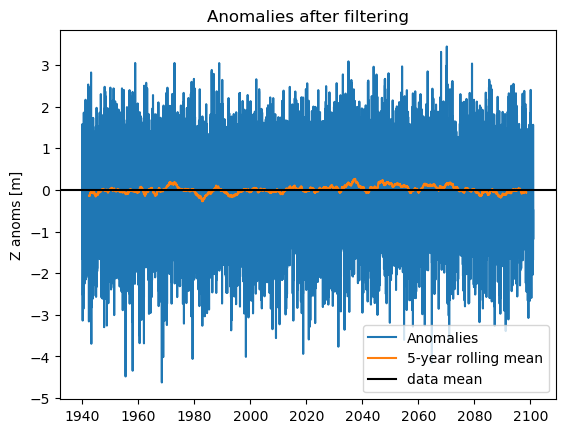

In [15]:
example_time_series = datasettest.Z_anom.sel(lat=39, lon=-77 + 360,method='nearest')
plt.plot(
    example_time_series.time, 
    example_time_series, 
    label='Anomalies'
)
plt.plot(
    example_time_series.time, 
    example_time_series.rolling(time=5 * 365, center=True).mean(skipna=True), 
    label='5-year rolling mean'
)
plt.axhline(
    np.mean(example_time_series),
    color='k',
    label='data mean'
)
plt.title('Anomalies after filtering')
plt.ylabel('Z anoms [m]')
plt.legend()
plt.show()

In [73]:
id_experiment = 0
name_experiment = unique_names_experiments[id_experiment]
print(name_experiment)
where_files = np.where(names_experiments_all==name_experiment)[0]
files_temp = filenames[where_files]
dataset_raw = extractz500_several_files(files_temp)

LE2-1001.001_cmip6


/glade/derecho/scratch/jhayron/tmp/ipykernel_52022/743903595.py:29: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  datetime_index = cftime_index.to_datetimeindex()


In [74]:
lat0=20; lat1=80; lon0=180; lon1=330
dataset_region = dataset_raw.where(
    (
        dataset_raw.lat>=lat0)&(
            dataset_raw.lat<=lat1)&(
            dataset_raw.lon>=lon0)&(
            dataset_raw.lon<=lon1),
    drop=True
)

In [77]:
clima = get_climatology_smoothed(dataset_region, 'Z500')
anoms = get_anomalies(dataset_region, 'Z500', clima)

(365, 64, 121)
(365, 64, 121)


In [82]:
anoms_filtered = fourierfilter(anoms.Z500_anom)
anoms_filtered = anoms_filtered.to_dataset(name='Z_anom')

/glade/derecho/scratch/jhayron/tmp/ipykernel_52022/4011791934.py:110: RuntimeWarning: divide by zero encountered in divide
  periods = np.abs(1 / freqs)


In [88]:
anoms_smooth = copy.deepcopy(anoms_filtered).rolling(time=60, center=True, min_periods=1).mean(skipna=True)
mean_series = get_weighted_area_average(anoms_smooth.Z_anom)
full_curve = copy.deepcopy(mean_series)
full_curve.data = np.zeros(len(full_curve))
npoly=3

doy_tmp = create_doy_dummy(len(np.unique(pd.to_datetime(mean_series.time).year)))

for i in range(0, 365): #Iterate through every day of the year

    doy_indx = doy_tmp[:, i]
    
    # fit a polynomial for the trend of each DOY
    params_curve = polynomial.polyfit(
        np.arange(0, mean_series[doy_indx].shape[0]), 
        mean_series[doy_indx], 
        npoly
    )
    curve = polynomial.polyval(
        np.arange(0, mean_series[doy_indx].shape[0]), 
        params_curve, 
        tensor=True
    )
    
    ## Center curve in zero
    full_curve.loc[{'time': mean_series[doy_indx].time}] = curve

anoms_detrended = anoms_filtered.Z_anom - full_curve.data[:, np.newaxis, np.newaxis]
anoms_detrended = anoms_detrended.to_dataset()

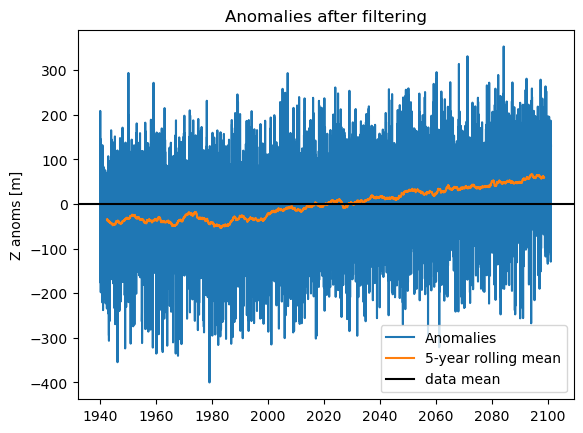

In [84]:
example_time_series = anoms_filtered.Z_anom.sel(lat=39, lon=-77 + 360,method='nearest')
plt.plot(
    example_time_series.time, 
    example_time_series, 
    label='Anomalies'
)
plt.plot(
    example_time_series.time, 
    example_time_series.rolling(time=5 * 365, center=True).mean(skipna=True), 
    label='5-year rolling mean'
)
plt.axhline(
    np.mean(example_time_series),
    color='k',
    label='data mean'
)
plt.title('Anomalies after filtering')
plt.ylabel('Z anoms [m]')
plt.legend()
plt.show()

Text(0, 0.5, 'Z [m]')

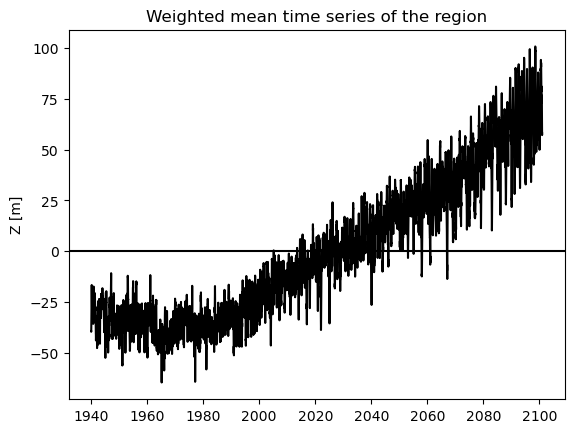

In [89]:
plt.plot(
    mean_series.time,
    mean_series,
    color='k'
)
plt.axhline(
    np.mean(mean_series),
    color='k'
)
plt.title('Weighted mean time series of the region')
plt.ylabel('Z [m]')

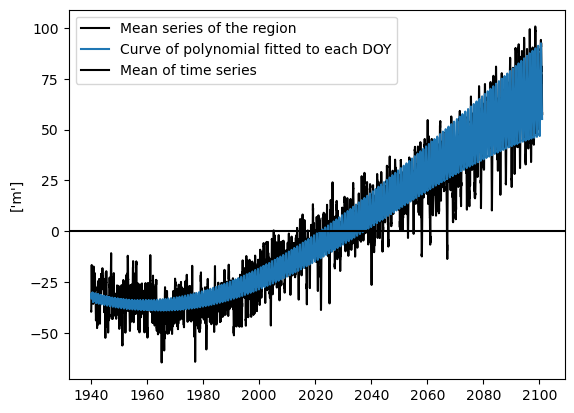

In [90]:
plt.plot(
    mean_series.time,
    mean_series,
    color='k',
    label='Mean series of the region'
)
plt.plot(
    full_curve.time,
    full_curve,
    label='Curve of polynomial fitted to each DOY'
)
plt.axhline(
    np.mean(mean_series),
    color='k',
    label='Mean of time series'
)
plt.ylabel(['m'])
plt.legend()
plt.show()

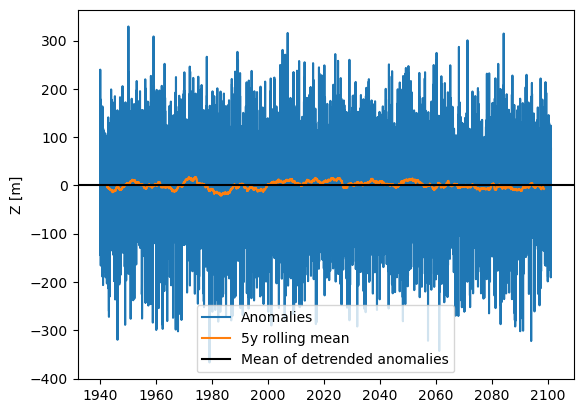

In [92]:
example_time_series = anoms_detrended.Z_anom.sel(lat=39, lon=-77 + 360,method='nearest')

plt.plot(
    example_time_series.time,
    example_time_series,
    label='Anomalies'
)
plt.plot(
    example_time_series.time,
    example_time_series.rolling(time=5 * 365,center=True).mean(skipna=True),
    label='5y rolling mean'
)
plt.axhline(
    np.mean(example_time_series),
    color='k',
    label='Mean of detrended anomalies'
)
plt.legend()
plt.ylabel('Z [m]')
plt.show()

In [93]:
clima_std = get_climatology_std_smoothed(anoms_detrended, 'Z_anom')
clima_std_average_region_series = get_weighted_area_average(clima_std)

anoms_standardized = copy.deepcopy(anoms_detrended).Z_anom
anoms_standardized.data = np.zeros_like(anoms_standardized.data)

doy_tmp = create_doy_dummy(len(np.unique(pd.to_datetime(mean_series.time).year)))

for i in range(0, 365): #Iterate through every day of the year

    doy_indx = doy_tmp[:, i]

    # grab doy std (climo)
    std_temp = clima_std_average_region_series.Z_anom_climo_std[i].data
    
    # standardize the detrended anoms by std climo
    standardized_temp = anoms_detrended.Z_anom[doy_indx].data / std_temp
    
    anoms_standardized.loc[{'time': anoms_detrended.Z_anom[doy_indx].time}] = standardized_temp

anoms_standardized = anoms_standardized.to_dataset()

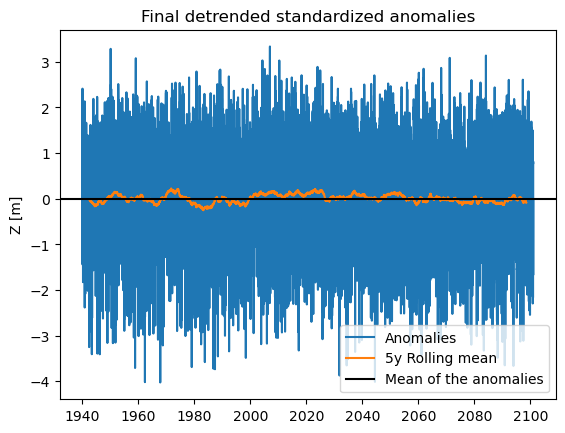

In [95]:
example_time_series = anoms_standardized.Z_anom.sel(lat=39, lon=-77 + 360,method='nearest')

plt.plot(
    example_time_series.time,
    example_time_series,
    label='Anomalies'
)
plt.plot(
    example_time_series.time,
    example_time_series.rolling(time=5 * 365, center=True).mean(skipna=True),
    label='5y Rolling mean'
)
plt.axhline(
    np.mean(example_time_series),
    color='k',
    label='Mean of the anomalies'
)
plt.legend()
plt.ylabel('Z [m]')
plt.title('Final detrended standardized anomalies')
plt.show()

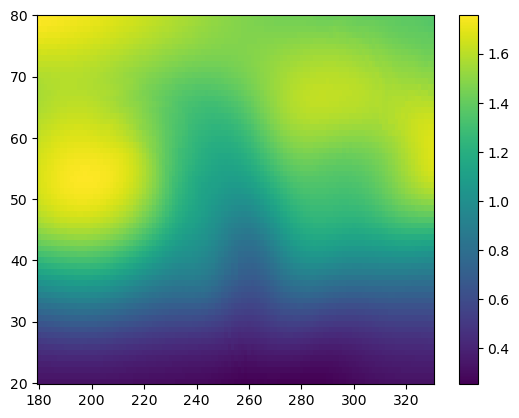

In [98]:
plt.pcolormesh(anoms_standardized.lon,anoms_standardized.lat,anoms_standardized.std('time').Z_anom)
plt.colorbar()
plt.show()

In [53]:
path_origins = '/glade/derecho/scratch/jhayron/Data4WRsClimateChange/ProcessedDataReanalyses/'
name_reanalysis = 'ERA5'

for name_reanalysis in ['ERA5','JRA3Q','NCEP_NCAR']:
    dataset_raw = xr.open_dataset(
        f'{path_origins}Z500_{name_reanalysis}.nc'
    )
    lat0=20; lat1=80; lon0=180; lon1=330
    dataset_region = dataset_raw.where(
        (
            dataset_raw.lat>=lat0)&(
                dataset_raw.lat<=lat1)&(
                dataset_raw.lon>=lon0)&(
                dataset_raw.lon<=lon1),
        drop=True
    )
    
    dataset_region.Z.data = dataset_region.Z.data / 9.82 ### Divide by gravity to convert from m2/s2 to m
    
    clima = get_climatology_smoothed(dataset_region, 'Z')
    anoms = get_anomalies(dataset_region, 'Z', clima)
    
    anoms_filtered = fourierfilter(anoms.Z_anom)
    anoms_filtered = anoms_filtered.to_dataset(name='Z_anom')
    anoms_smooth = copy.deepcopy(anoms_filtered).rolling(time=60, center=True, min_periods=1).mean(skipna=True)
    mean_series = get_weighted_area_average(anoms_smooth.Z_anom)
    full_curve = copy.deepcopy(mean_series)
    full_curve.data = np.zeros(len(full_curve))
    npoly=3
    
    doy_tmp = create_doy_dummy(len(np.unique(pd.to_datetime(mean_series.time).year)))
    
    for i in range(0, 365): #Iterate through every day of the year
    
        doy_indx = doy_tmp[:, i]
        
        # fit a polynomial for the trend of each DOY
        params_curve = polynomial.polyfit(
            np.arange(0, mean_series[doy_indx].shape[0]), 
            mean_series[doy_indx], 
            npoly
        )
        curve = polynomial.polyval(
            np.arange(0, mean_series[doy_indx].shape[0]), 
            params_curve, 
            tensor=True
        )
        
        ## Center curve in zero
        full_curve.loc[{'time': mean_series[doy_indx].time}] = curve
    
    anoms_detrended = anoms_filtered.Z_anom - full_curve.data[:, np.newaxis, np.newaxis]
    anoms_detrended = anoms_detrended.to_dataset()
    clima_std = get_climatology_std_smoothed(anoms_detrended, 'Z_anom')
    clima_std_average_region_series = get_weighted_area_average(clima_std)
    
    anoms_standardized = copy.deepcopy(anoms_detrended).Z_anom
    anoms_standardized.data = np.zeros_like(anoms_standardized.data)
    
    doy_tmp = create_doy_dummy(len(np.unique(pd.to_datetime(mean_series.time).year)))
    
    for i in range(0, 365): #Iterate through every day of the year
    
        doy_indx = doy_tmp[:, i]
    
        # grab doy std (climo)
        std_temp = clima_std_average_region_series.Z_anom_climo_std[i].data
        
        # standardize the detrended anoms by std climo
        standardized_temp = anoms_detrended.Z_anom[doy_indx].data / std_temp
        
        anoms_standardized.loc[{'time': anoms_detrended.Z_anom[doy_indx].time}] = standardized_temp
    
    anoms_standardized = anoms_standardized.to_dataset()
    anoms_standardized.to_netcdf(f'{path_origins}Z500Anoms_{name_reanalysis}.nc')

(365, 61, 151)
(365, 61, 151)


/glade/derecho/scratch/jhayron/tmp/ipykernel_15480/1441930984.py:115: RuntimeWarning: divide by zero encountered in divide
  periods = np.abs(1 / freqs)


(365, 61, 151)
(365, 61, 151)


/glade/derecho/scratch/jhayron/tmp/ipykernel_15480/1441930984.py:115: RuntimeWarning: divide by zero encountered in divide
  periods = np.abs(1 / freqs)


(365, 25, 61)
(365, 25, 61)


/glade/derecho/scratch/jhayron/tmp/ipykernel_15480/1441930984.py:115: RuntimeWarning: divide by zero encountered in divide
  periods = np.abs(1 / freqs)
